In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing


In [2]:
#reading the values from the database
df1 = pd.read_csv("bank-additional-full.csv",sep=";")

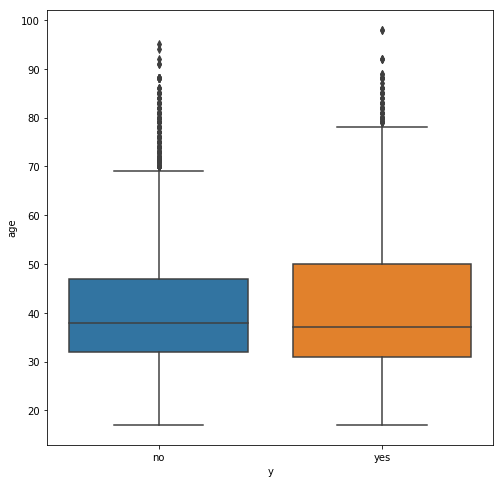

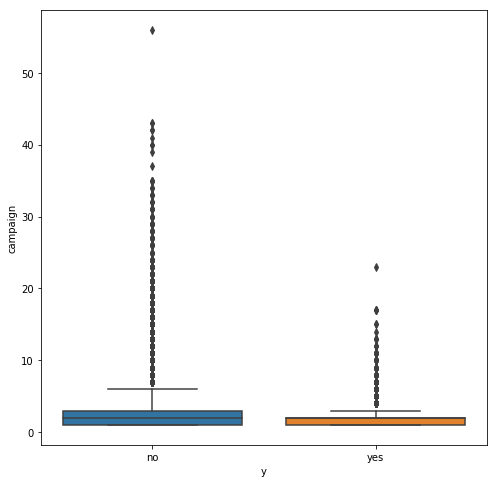

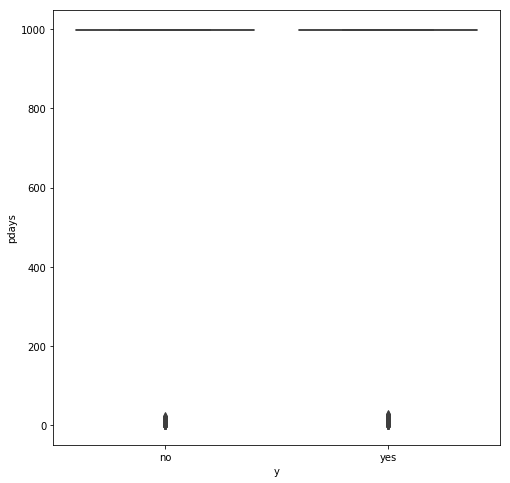

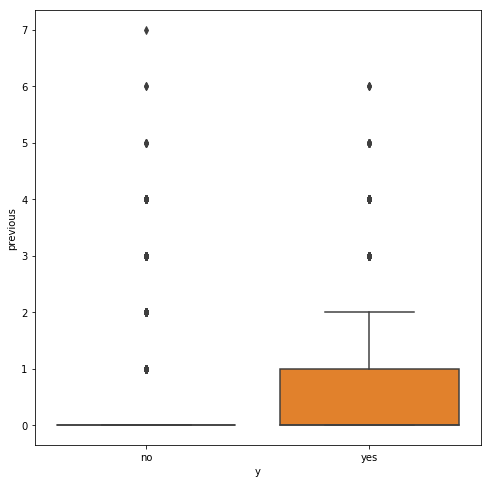

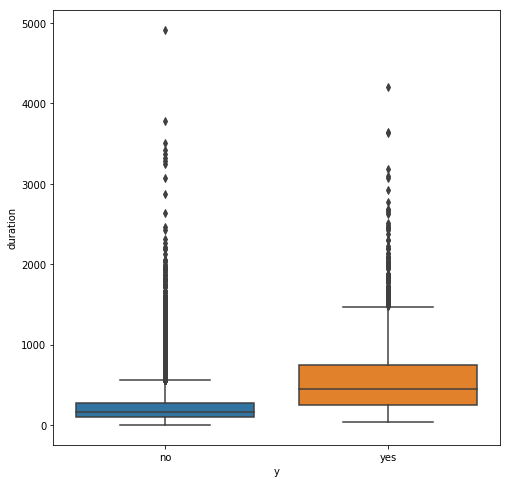

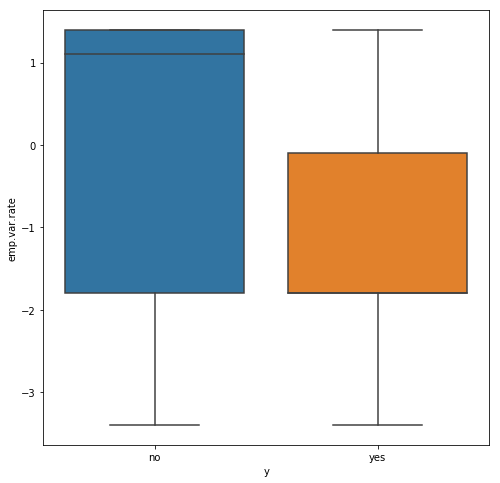

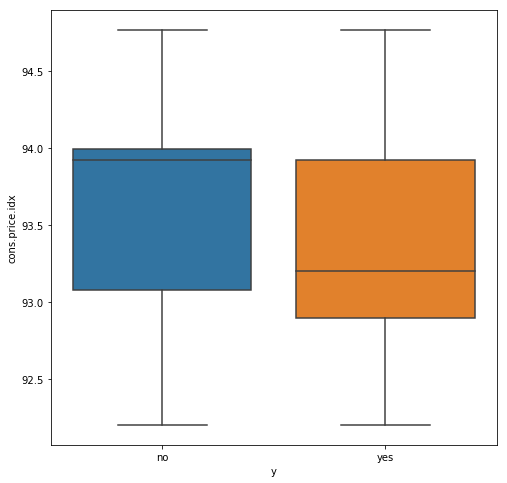

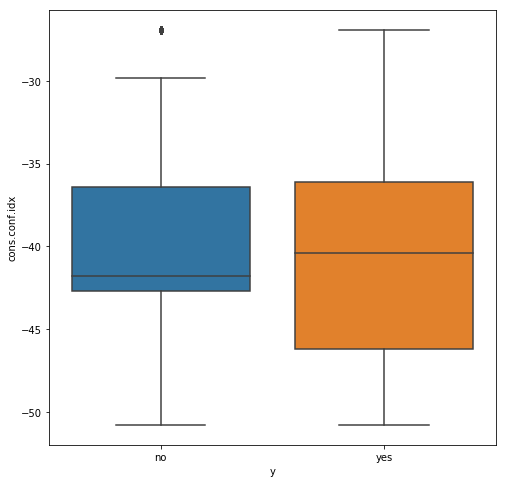

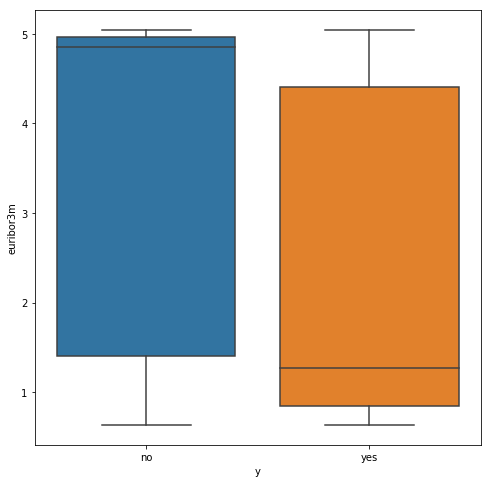

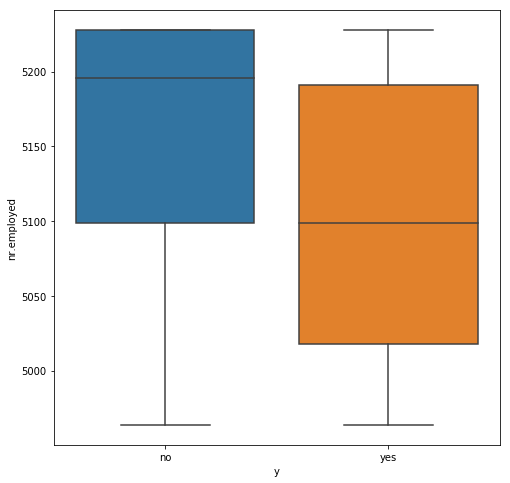

In [3]:
#the following columns have numeric data type hence we create a separate variable to store the column name
numeric_vars=["age", "campaign", "pdays", "previous", "duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
#category names are the columns which does not have numeric values
categorical_vars=[i for i in df1.columns if i not in numeric_vars]
#we remove the output y
categorical_vars.remove("y")
target="y"
#visualizing the dependence of output on the input.
for i in numeric_vars:
    plt.figure(figsize=(8,8))
    sns.boxplot(x=target,y=i,data=df1)
    plt.show()

In [5]:
#one hot encoding the columns with non-numerical values to send to the model.To do this,we have to first convert
# the strings to label encoding and then do one hot encoding
enc = preprocessing.LabelEncoder()
enc.fit(categorical_vars)
new_cat_features = enc.transform(categorical_vars)
new_cat_features = new_cat_features.reshape(-1, 1) 
ohe = preprocessing.OneHotEncoder(sparse=False)
tr = ohe.fit_transform(new_cat_features)


/home/shouvik/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
#removing unnecessary columns
df1=df1.drop(categorical_vars,axis=1)

In [7]:
df1=df1.drop("pdays",axis=1)

In [8]:
numeric_vars.remove("pdays")

In [11]:
X = df1[[i for i in df1.columns if i != "y"]]  #independent columns
y = df1["y"]    #Output for the customer 

Now we need to understand the column on which the outcome of the user depends the most. To do this, we train an extra tree classifier model. It fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

/home/shouvik/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[ 0.16362013  0.42779742  0.07242947  0.02599557  0.0363457   0.01776304
  0.02774763  0.16201478  0.06628626]


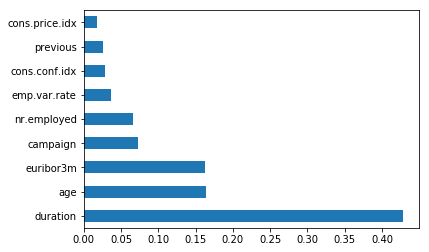

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
#find the importance of each column on the result of the user.
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

We can clearly see that duration column is most important column for the prediction.

In [13]:
df_select=df1[feat_importances.nlargest(20).index.values]
df_select["y"]=df1["y"]
X=df_select[[i for i in df_select.columns if i != "y"]].values
y=df_select["y"].values

We also fit the data on XGBoost model to gain more insights on the importance of the columns on the output y.

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = .1,
                                                  random_state=12)

In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics
#applying somte for oversampling...
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [17]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds,verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(metrics.classification_report(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

In [18]:
predictors = [x for x in df_select.columns if x not in [target]]
df_res=pd.DataFrame(x_train_res,columns=predictors)
df_res["y"]=y_train_res

[0]	train-logloss:0.645102+0.00757874	test-logloss:0.645311+0.00754714
[1]	train-logloss:0.593927+0.010922	test-logloss:0.594226+0.011277
[2]	train-logloss:0.550037+0.0111686	test-logloss:0.550418+0.0116172
[3]	train-logloss:0.517723+0.0104079	test-logloss:0.518234+0.0110613
[4]	train-logloss:0.486424+0.00807846	test-logloss:0.487108+0.00877141
[5]	train-logloss:0.460055+0.0103038	test-logloss:0.460803+0.0106457
[6]	train-logloss:0.436086+0.0127134	test-logloss:0.436855+0.0132572
[7]	train-logloss:0.410906+0.0098686	test-logloss:0.411788+0.0105204
[8]	train-logloss:0.389212+0.00763253	test-logloss:0.390233+0.00842027
[9]	train-logloss:0.370559+0.00556642	test-logloss:0.371649+0.00647157
[10]	train-logloss:0.353171+0.00462014	test-logloss:0.354402+0.00562124
[11]	train-logloss:0.340195+0.00599859	test-logloss:0.341539+0.00667868
[12]	train-logloss:0.327485+0.00435688	test-logloss:0.328821+0.00542242
[13]	train-logloss:0.316742+0.00537018	test-logloss:0.318095+0.00661543
[14]	train-loglo

[113]	train-logloss:0.129581+0.00100571	test-logloss:0.136996+0.00051312
[114]	train-logloss:0.129264+0.000918852	test-logloss:0.136721+0.000453692
[115]	train-logloss:0.128943+0.000880814	test-logloss:0.136455+0.000469065
[116]	train-logloss:0.128614+0.000811155	test-logloss:0.136203+0.000478211
[117]	train-logloss:0.128156+0.00077226	test-logloss:0.135794+0.000426164
[118]	train-logloss:0.12786+0.000810829	test-logloss:0.135534+0.000463787
[119]	train-logloss:0.127586+0.000875169	test-logloss:0.13535+0.000589122
[120]	train-logloss:0.127312+0.000898245	test-logloss:0.135111+0.000666158
[121]	train-logloss:0.127057+0.00087376	test-logloss:0.134904+0.000715856
[122]	train-logloss:0.126856+0.000835954	test-logloss:0.134761+0.00073768
[123]	train-logloss:0.126484+0.000871171	test-logloss:0.134447+0.000622683
[124]	train-logloss:0.126224+0.000854855	test-logloss:0.134244+0.000689073
[125]	train-logloss:0.125981+0.000857307	test-logloss:0.13403+0.000624505
[126]	train-logloss:0.125718+0.00

[224]	train-logloss:0.105001+0.000841154	test-logloss:0.118001+0.000462808
[225]	train-logloss:0.104816+0.000894661	test-logloss:0.117885+0.000468279
[226]	train-logloss:0.104683+0.000927351	test-logloss:0.117825+0.000462478
[227]	train-logloss:0.104535+0.000919848	test-logloss:0.117721+0.000374473
[228]	train-logloss:0.104403+0.000899628	test-logloss:0.11763+0.000417059
[229]	train-logloss:0.104266+0.000935772	test-logloss:0.117546+0.000392923
[230]	train-logloss:0.104105+0.000943381	test-logloss:0.117448+0.000341093
[231]	train-logloss:0.103959+0.000953625	test-logloss:0.117362+0.000377907
[232]	train-logloss:0.103816+0.000978382	test-logloss:0.117263+0.000372521
[233]	train-logloss:0.10359+0.000973669	test-logloss:0.117067+0.000396457
[234]	train-logloss:0.103404+0.000984944	test-logloss:0.116944+0.000484048
[235]	train-logloss:0.103241+0.000950645	test-logloss:0.116815+0.000473214
[236]	train-logloss:0.103088+0.000973006	test-logloss:0.116725+0.000452509
[237]	train-logloss:0.10291

[333]	train-logloss:0.0924086+0.00065112	test-logloss:0.11083+0.000861283
[334]	train-logloss:0.092323+0.000615191	test-logloss:0.110784+0.000898325
[335]	train-logloss:0.0922042+0.000600332	test-logloss:0.110676+0.000884935
[336]	train-logloss:0.0921048+0.000595095	test-logloss:0.110613+0.000907468
[337]	train-logloss:0.0920366+0.000601122	test-logloss:0.110587+0.000901389
[338]	train-logloss:0.0919464+0.000611502	test-logloss:0.110549+0.000895663
[339]	train-logloss:0.0918686+0.000615966	test-logloss:0.110524+0.000902052
[340]	train-logloss:0.0917942+0.000608006	test-logloss:0.110523+0.000899698
[341]	train-logloss:0.0916988+0.000621559	test-logloss:0.110447+0.000924174
[342]	train-logloss:0.0916024+0.00060215	test-logloss:0.110404+0.000938624
[343]	train-logloss:0.0915228+0.00062554	test-logloss:0.110373+0.000904396
[344]	train-logloss:0.0914166+0.000655126	test-logloss:0.110318+0.000905265
[345]	train-logloss:0.0913516+0.000654922	test-logloss:0.110315+0.000900661
[346]	train-loglo

[443]	train-logloss:0.0842822+0.000538921	test-logloss:0.107738+0.00120538
[444]	train-logloss:0.0842092+0.000549522	test-logloss:0.107714+0.00120099
[445]	train-logloss:0.0841604+0.000560199	test-logloss:0.107694+0.00120294
[446]	train-logloss:0.0840932+0.00055553	test-logloss:0.107681+0.00120665
[447]	train-logloss:0.0840198+0.000556752	test-logloss:0.107654+0.00122077
[448]	train-logloss:0.0839534+0.000543173	test-logloss:0.107626+0.0012255
[449]	train-logloss:0.0838884+0.000561366	test-logloss:0.10761+0.00122628
[450]	train-logloss:0.0838392+0.000559929	test-logloss:0.107594+0.00123044
[451]	train-logloss:0.0837888+0.000548622	test-logloss:0.107581+0.00124554
[452]	train-logloss:0.0837286+0.000532469	test-logloss:0.107569+0.00125101
[453]	train-logloss:0.083671+0.000518513	test-logloss:0.107547+0.00124687
[454]	train-logloss:0.0836108+0.000511633	test-logloss:0.107536+0.00126442
[455]	train-logloss:0.0835478+0.000509249	test-logloss:0.107483+0.00124292
[456]	train-logloss:0.0834842

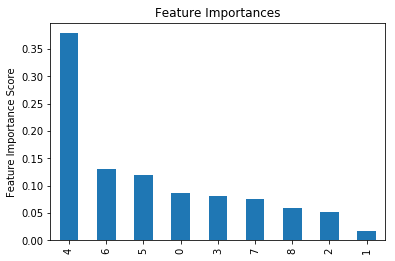

In [19]:
xgb1= XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, df_res, predictors)

In [20]:
print('Validation Results')

dtest_predictions = xgb1.predict(pd.DataFrame(x_val,columns=predictors))
dtest_predprob = xgb1.predict_proba(pd.DataFrame(x_val,columns=predictors))[:,1]

print(metrics.classification_report(y_val, dtest_predictions))

Validation Results
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3666
           1       0.60      0.60      0.60       453

   micro avg       0.91      0.91      0.91      4119
   macro avg       0.77      0.77      0.77      4119
weighted avg       0.91      0.91      0.91      4119



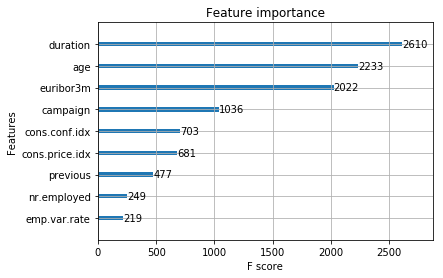

In [24]:
from xgboost import plot_importance
plot_importance(xgb1)

plt.show()

From both of the above plots, we find that duration is the most important feature in customers saying yes.

In [26]:
from sklearn.feature_extraction import DictVectorizer
data = pd.read_csv("bank-additional-full.csv", sep=';')
data_dict = data.T.to_dict().values()
vec = DictVectorizer()
signal_array = vec.fit_transform(data_dict).toarray()
feature_names = vec.get_feature_names()

In [29]:
df = pd.DataFrame(signal_array,columns=feature_names)

In [31]:
print("Nth Call \t Efficiency")
for i in range(1,30):
    goo = sum(df.loc[df['campaign']==i]['y=yes']) / float(df.loc[df['campaign'] >= i].shape[0])
    print (str((i))+" \t\t "+str(goo))

Nth Call 	 Efficiency
1 		 0.0558415072351
2 		 0.0514312409751
3 		 0.0442355117139
4 		 0.0326129666012
5 		 0.024077046549
6 		 0.0221565731167
7 		 0.0157938487116
8 		 0.00956668542487
9 		 0.0123456790123
10 		 0.0109689213894
11 		 0.0138089758343
12 		 0.00433526011561
13 		 0.00705467372134
14 		 0.00210526315789
15 		 0.00492610837438
16 		 0.0
17 		 0.0131578947368
18 		 0.0
19 		 0.0
20 		 0.0
21 		 0.0
22 		 0.0
23 		 0.00862068965517
24 		 0.0
25 		 0.0
26 		 0.0
27 		 0.0
28 		 0.0
29 		 0.0


The Market acceptable conversion ratio is 2-10% so it is a fair to say any call after the 6th call is not acceptable since it has a conversion ratio of less than 1.6%.

In [37]:
# Calculate how many calls were made in total
total_calls = sum(df['campaign'])
print("total_calls:",total_calls)
# Calculate how many calls were made after the 6th call
extra_calls = sum(df[df['campaign']>6]['campaign']) - 6*df[df['campaign']>6].shape[0]
print("extra_calls",extra_calls)
#calculate the total sales
total_sales=float(df[df['y=yes']==1].shape[0])
# Calculate reduction in marketing cost
reduction=100*extra_calls/total_calls
print("sales_reduction:",reduction)
print("total_sales",total_sales)
#considering only the sales which required less than 6 calls
less_costly_sales=float(df[(df['campaign'] <= 6) & (df['y=yes']==1)].shape[0])
print("less_costly_sales",less_costly_sales)
#final sales after removing the customers which required more than 6 calls to convince
sales_percent=100*less_costly_sales/total_sales
print("sales_percent:",sales_percent)

total_calls: 105754.0
extra_calls 12040.0
sales_reduction: 11.3849121546
total_sales 4640.0
less_costly_sales 4529.0
sales_percent: 97.60775862068965


Hence a reduction of about 11.4% in marketing cost can be achieved while maintaining 97.6% sales if any person is called a maximum of 6 times.